In [502]:
cd

/Users/viktorvandervalk


In [503]:
cd Documents/GitHub/DataMiningTechniques/Assignment\ 1

/Users/viktorvandervalk/Documents/GitHub/DataMiningTechniques/Assignment 1


In [504]:
cd patient_data/

/Users/viktorvandervalk/Documents/GitHub/DataMiningTechniques/Assignment 1/patient_data


In [108]:
import pandas as pd
import pickle
from datetime import datetime
import re
from matplotlib import pyplot as plt
import numpy as np
#from sklearn import tree
#from sklearn.ensemble import RandomForestClassifier
import sklearn.ensemble as ske
#import graphviz 
#from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, scale
import math
#from sklearn.decomposition import PCA
#from sklearn.neighbors import KNeighborsRegressor

In [ ]:
data_best_F_mse = pd.read_csv('Best_F_MSE', index_col=0, usecols=range(0,11))
data_best_F_corr = pd.read_csv('Best_F_Corr.csv',  index_col=0, usecols=range(1,12))

In [852]:
# LSTM Time Series Training Network

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#LSTM_opt = np.zeros([6,9])

#for n_features in [2]:
#    for lag in [3]:

n_features = 9
lag = 1
predicted = []
real = []
mses = []

#for i in range(12):  # Walter
#for i in range(12, 23): # Arran
for i in [25]: # Viktor

    
    squared_error = []
        # load patient data
    try:
        data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)
    except:
        continue

    print('\n --- Patient {:02d} ---'.format(i))

    #data_reindexed = data.loc[:,data_best_F_mse.loc[i].values]
    data_reindexed = data.loc[:,data_best_F_corr.loc[i].values]

    dataset = data_reindexed.iloc[:,:n_features]
    values = dataset.values

    seg = [0.7, 0.1, 0.2]
    t = len(dataset)
    splits = [math.floor(seg[0]*t), math.floor((seg[0]+seg[1])*t)]

    #ys = values[splits[0]:,0]
    ys = values[splits[1]:,0]

    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, lag, 1)

    # split into train and test sets
    values = reframed.values

    #for tt in range(t-splits[0]-1-math.floor((seg[2]*t))):
    for tt in range(t-splits[1]-lag):

        #train = values[:splits[0]+tt, :]
        train = values[:splits[1]+tt, :]
        #test = values[splits[0]+tt:splits[0]+math.floor((seg[1]*t)), :]
        test = values[splits[1]+tt:, :]
        #val = values[splits[0]+tt,:]
        val = values[splits[1]+tt,:]

        # split into input and outputs
        n_obs = lag * n_features
        train_X, train_y = train[:, :n_obs], train[:, -n_features]
        test_X, test_y = test[:, :n_obs], test[:, -n_features]
        val_X, val_y = val[:n_obs], val[-n_features]

        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], lag, n_features))
        test_X = test_X.reshape((test_X.shape[0], lag, n_features))
        val_X = val_X.reshape((1, lag, n_features))

        # design network
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam');
        # fit network
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False);
        
        # Plot training fase.
        #pyplot.plot(history.history['loss'], label='train')
        #pyplot.plot(history.history['val_loss'], label='test')
        #pyplot.legend()
        #pyplot.savefig('LSTM Training')
        #pyplot.show()
        
        # make a prediction
        yhat = model.predict(val_X)
        val_X = val_X.reshape((val_X.shape[0], lag*n_features))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, val_X[:, -(n_features-1):]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[0][0]

        inv_y = ys[tt+lag]

        # calculate RMSE
        print('Predicted:', inv_yhat)
        print('Real:', inv_y)
        squared_error.append((inv_y - inv_yhat)**2)
        predicted.append(inv_yhat)
        real.append(inv_y)

    mse = np.mean(squared_error)
    print('\nMSE: {}'.format(mse))
    #print('Number of validations:', math.floor(t*seg[1]))
    mses.append(mse)
    
print('All MSES',mses)
        #LSTM_opt[lag, n_features] = np.mean(mses)
print('\n\nAvg. MSE (all patients): {} \n lag order: {} \n nr of features: {} '.format(np.mean(mses), lag, n_features))


 --- Patient 25 ---
Train on 23 samples, validate on 6 samples
Epoch 1/50
 - 190s - loss: 0.3886 - val_loss: 0.3150
Epoch 2/50
 - 0s - loss: 0.3774 - val_loss: 0.3041
Epoch 3/50
 - 0s - loss: 0.3671 - val_loss: 0.2933
Epoch 4/50
 - 0s - loss: 0.3576 - val_loss: 0.2825
Epoch 5/50
 - 0s - loss: 0.3486 - val_loss: 0.2723
Epoch 6/50
 - 0s - loss: 0.3400 - val_loss: 0.2615
Epoch 7/50
 - 0s - loss: 0.3315 - val_loss: 0.2509
Epoch 8/50
 - 0s - loss: 0.3239 - val_loss: 0.2404
Epoch 9/50
 - 0s - loss: 0.3164 - val_loss: 0.2299
Epoch 10/50
 - 0s - loss: 0.3089 - val_loss: 0.2195
Epoch 11/50
 - 0s - loss: 0.3014 - val_loss: 0.2090
Epoch 12/50
 - 0s - loss: 0.2939 - val_loss: 0.1986
Epoch 13/50
 - 0s - loss: 0.2864 - val_loss: 0.1881
Epoch 14/50
 - 0s - loss: 0.2789 - val_loss: 0.1776
Epoch 15/50
 - 0s - loss: 0.2719 - val_loss: 0.1672
Epoch 16/50
 - 0s - loss: 0.2652 - val_loss: 0.1567
Epoch 17/50
 - 0s - loss: 0.2592 - val_loss: 0.1466
Epoch 18/50
 - 0s - loss: 0.2546 - val_loss: 0.1366
Epoch 1

Epoch 4/50
 - 0s - loss: 0.2933 - val_loss: 0.2140
Epoch 5/50
 - 0s - loss: 0.2853 - val_loss: 0.2030
Epoch 6/50
 - 0s - loss: 0.2778 - val_loss: 0.1919
Epoch 7/50
 - 0s - loss: 0.2705 - val_loss: 0.1811
Epoch 8/50
 - 0s - loss: 0.2640 - val_loss: 0.1703
Epoch 9/50
 - 0s - loss: 0.2585 - val_loss: 0.1597
Epoch 10/50
 - 0s - loss: 0.2540 - val_loss: 0.1494
Epoch 11/50
 - 0s - loss: 0.2496 - val_loss: 0.1393
Epoch 12/50
 - 0s - loss: 0.2455 - val_loss: 0.1296
Epoch 13/50
 - 0s - loss: 0.2424 - val_loss: 0.1203
Epoch 14/50
 - 0s - loss: 0.2400 - val_loss: 0.1116
Epoch 15/50
 - 0s - loss: 0.2376 - val_loss: 0.1032
Epoch 16/50
 - 0s - loss: 0.2354 - val_loss: 0.0953
Epoch 17/50
 - 0s - loss: 0.2336 - val_loss: 0.0881
Epoch 18/50
 - 0s - loss: 0.2323 - val_loss: 0.0814
Epoch 19/50
 - 0s - loss: 0.2310 - val_loss: 0.0751
Epoch 20/50
 - 0s - loss: 0.2297 - val_loss: 0.0692
Epoch 21/50
 - 0s - loss: 0.2286 - val_loss: 0.0640
Epoch 22/50
 - 0s - loss: 0.2278 - val_loss: 0.0593
Epoch 23/50
 - 0s 

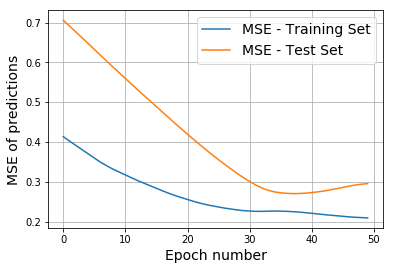

In [850]:
pyplot.plot(history.history['loss'], label='MSE - Training Set')
pyplot.plot(history.history['val_loss'], label='MSE - Test Set')
pyplot.xlabel('Epoch number', fontsize=14)
pyplot.ylabel('MSE of predictions', fontsize=14)
pyplot.legend(fontsize=14)
pyplot.grid()
pyplot.savefig('LSTM Training')
pyplot.show()

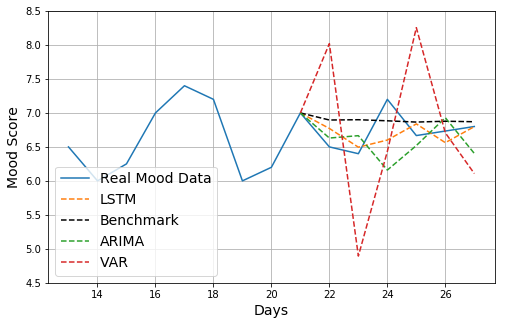

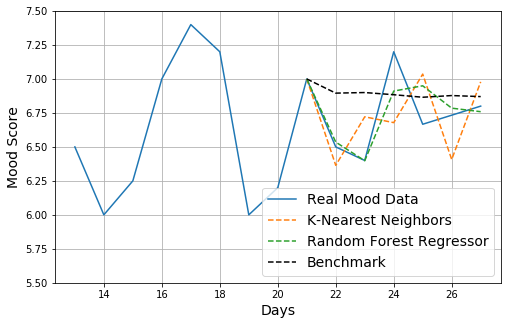

In [881]:
mood_data = data.loc[:,'mood'].values

predicted_LSTM = np.zeros(len(predicted)+1)
predicted_LSTM[1:] = predicted
predicted_LSTM[0] = 7.0

predicted_RF_data = np.zeros(len(predicted_RF)+1)
predicted_RF_data[1:] = predicted_RF
predicted_RF_data[0] = 7.0

predicted_KNN_data = np.zeros(len(predicted_KNN)+1)
predicted_KNN_data[1:] = predicted_KNN
predicted_KNN_data[0] = 7.0

predicted_BM_data = np.zeros(len(predicted_BM)+1)
predicted_BM_data[1:] = predicted_BM
predicted_BM_data[0] = 7.0


predicted_VAR = [8.019880462827052,4.8933928130515065,6.433489854360946,8.254654583382257,6.707363230117877,6.107742004732319,7.37502568707073]
predicted_VAR_data = np.zeros(len(predicted_VAR)+1)
predicted_VAR_data[1:] = predicted_VAR
predicted_VAR_data[0] = 7.0

predicted_ARIMA = [6.630504538552541,6.665223441825722,6.159159487933257,6.519792058435408,6.929620039743026,6.403720650069846,6.8725666360635325]
predicted_ARIMA_data = np.zeros(len(predicted_ARIMA)+1)
predicted_ARIMA_data[1:] = predicted_ARIMA
predicted_ARIMA_data[0] = 7.0


time_steps = range(len(mood_data))

plt.figure(figsize=[8,5])

plt.xlabel('Days',fontsize=14)
plt.ylabel('Mood Score', fontsize=14)

plt.plot(time_steps[13:], x_p[15:], label= 'Real Mood Data')
plt.plot(time_steps[-len(predicted_LSTM):], predicted_LSTM, linestyle = 'dashed',label='LSTM')
plt.plot(time_steps[-len(predicted_LSTM):], predicted_BM_data[:-1], linestyle = 'dashed',label='Benchmark', color='k')
plt.plot(time_steps[-len(predicted_LSTM):], predicted_ARIMA_data[:-1], linestyle = 'dashed',label='ARIMA')
plt.plot(time_steps[-len(predicted_LSTM):], predicted_VAR_data[:-1], linestyle = 'dashed',label='VAR')

plt.grid()
plt.legend(fontsize=14)
ax = plt.gca()
ax.set_ylim(4.5, 8.5)
plt.savefig('Prediction Temporal Models')
plt.show()

plt.figure(figsize=[8,5])

plt.xlabel('Days',fontsize=14)
plt.ylabel('Mood Score', fontsize=14)

plt.plot(time_steps[13:], x_p[15:], label= 'Real Mood Data')

plt.plot(time_steps[-len(predicted_LSTM):], predicted_KNN_data[:-1], linestyle = 'dashed',label='K-Nearest Neighbors')
plt.plot(time_steps[-len(predicted_LSTM):], predicted_RF_data[:], linestyle = 'dashed',label='Random Forest Regressor')
plt.plot(time_steps[-len(predicted_LSTM):], predicted_BM_data[:-1], linestyle = 'dashed',label='Benchmark', color='k')
plt.grid()
plt.legend(fontsize=14)
ax = plt.gca()
ax.set_ylim(5.5, 7.5)
plt.savefig('Prediction Non-Temporal Models')
plt.show()


In [864]:
# Good KNN and RF model

KNN_Opt= np.zeros([11,11])
RF_Opt = np.zeros([11,11])

#predicted_KNN = []
predicted_RF = []
#Real_KNN_RF = []


#for n_features in [9,10]:
#    for lag in [1,2,3,4]:
        
# KNN Best features = 7, lag=1, method = corr, 7 neighbors
msesKNN = []
msesRF = []

n_features = 10
lag = 3
neighbors = 7

# RF Best features = 10, lag = 3, method = mse.

#n_features = 10

#for i in [1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33]:
for i in [25]:

    try:
        mood_data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)
        if lag==1:
            data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)  
        elif lag==2:
            data = pd.read_csv(open('p{:02d}_k2.csv'.format(i),'rb'), index_col=0, parse_dates=True)
        elif lag==3:
            data = pd.read_csv(open('p{:02d}_k3.csv'.format(i),'rb'), index_col=0, parse_dates=True)
        elif lag==4:
            data = pd.read_csv(open('p{:02d}_k4.csv'.format(i),'rb'), index_col=0, parse_dates=True)
    except:
        continue

    print('\n --- Patient {:02d} ---'.format(i))

    # Get features with highest MSE    
    #data_reindexed = data.loc[:,data_best_F_mse.loc[i].values]
    #dataset = data_reindexed.iloc[:,:(n_features+1)]

    # Get features with highest correlation
    data_reindexed = data.loc[:,data_best_F_corr.loc[i].values]
    dataset = data_reindexed.iloc[:,:(n_features+1)]

    x_p = dataset.values
    y_p = data.loc[:,'next_mood'].values

    # Principal Components Analysis
    #pca = PCA(n_components=10)
    pca_data = scale(x_p, axis=0)
    #x_pca = pca.fit_transform(pca_data)

    x_pca = pca_data

    # Train, test, validation set
    seg = [0.7, 0.1, 0.2]
    t = len(data)
    splits = [math.floor(seg[0]*t), math.floor((seg[0]+seg[1])*t)]

    train_x, train_y = x_pca[:splits[0]], y_p[:splits[0]]
    train2_x, train2_y = x_pca[:splits[1]], y_p[:splits[1]]   # includes validation data


    squared_errorKNN = []
    squared_errorRF = []


    for t in range(len(train2_x), len(y_p)):

    #for t in range(len(train_x), len(train2_x)):

        # KNN
        #knn = KNeighborsRegressor(n_neighbors =n_features-8)
        #knn.fit(train2_x[:t,:], train2_y[:t])
        #yhatKNN = knn.predict(train2_x[t,:].reshape(1,-1))

        # RandomForest
        #clf = ske.RandomForestRegressor(n_estimators=1, max_features=n_features)
        #clf = clf.fit(train2_x[:t,:], train2_y[:t])
        #yhatRF = clf.predict(train2_x[t,:].reshape(1,-1))

        # Final Test
        knn = KNeighborsRegressor(n_neighbors =neighbors)
        knn.fit(x_pca[:t,:], y_p[:t])
        yhatKNN = knn.predict(x_pca[t,:].reshape(1,-1))
        #
        clf = ske.RandomForestRegressor(n_estimators=2000, max_features=10)
        clf = clf.fit(x_pca[:t,:], y_p[:t])
        yhatRF = clf.predict(x_pca[t,:].reshape(1,-1))

        obs = y_p[t]
        #obs = train2_y[t]
        print('Predicted KNN: {:%s}, Predicted RFR: {:%s}, Observed: {:%s}' %(yhatKNN, yhatRF, obs))
        squared_errorKNN.append((obs - yhatKNN)**2)
        squared_errorRF.append((obs - yhatRF)**2)
        #predicted_KNN.append(yhatKNN)
        predicted_RF.append(yhatRF)
        #Real_KNN_RF.append(obs)

    mseKNN = np.mean(squared_errorKNN)
    mseRF = np.mean(squared_errorRF)

    print('\nMSE KNN: {}'.format(mseKNN))
    msesKNN.append(mseKNN)

    print('\nMSE RF: {}'.format(mseRF))
    msesRF.append(mseRF)

print('\n\nAvg. MSE KNN (all patients): {}, lag: {}'.format(np.mean(msesKNN), lag))

#KNN_Opt[n_features,lag] = np.mean(msesKNN)

KNN_Final_MSE = np.mean(msesKNN)


print('\n\nAvg. MSE RF (all patients): {}, lag: {}'.format(np.mean(msesRF), lag))

#RF_Opt[n_features, lag] = np.mean(msesRF)

RF_Final_MSE = np.mean(msesRF)



 --- Patient 25 ---
Predicted KNN: {:[6.82142857]}, Predicted RFR: {:[6.53535]}, Observed: {:6.4}
Predicted KNN: {:[6.85714286]}, Predicted RFR: {:[6.398225]}, Observed: {:7.2}
Predicted KNN: {:[6.85714286]}, Predicted RFR: {:[6.910775]}, Observed: {:6.666666666666668}
Predicted KNN: {:[6.81666667]}, Predicted RFR: {:[6.94959167]}, Observed: {:6.7333333333333325}
Predicted KNN: {:[6.92857143]}, Predicted RFR: {:[6.78510833]}, Observed: {:6.8}
Predicted KNN: {:[6.72857143]}, Predicted RFR: {:[6.75913333]}, Observed: {:7.0}

MSE KNN: 0.07143046107331823

MSE RF: 0.13762630518520388


Avg. MSE KNN (all patients): 0.07143046107331823, lag: 3


Avg. MSE RF (all patients): 0.13762630518520388, lag: 3


In [700]:
# Calculate Confidence Interval

std_KNN = np.std(msesKNN, ddof=1)
std_RF = np.std(msesRF, ddof=1)
 
       
upper_bound_KNN = KNN_Final_MSE + (2.06*std_KNN/np.sqrt(27))
lower_bound_KNN = KNN_Final_MSE - (2.06*std_KNN/np.sqrt(27))

upper_bound_RF = RF_Final_MSE + (2.06*std_RF/np.sqrt(27))
lower_bound_RF = RF_Final_MSE - (2.06*std_RF/np.sqrt(27))
    
print('KNN: Mean, Std, Lower Bound, Upperbound \n', KNN_Final_MSE, std_KNN, lower_bound_KNN, upper_bound_KNN)
print('RF: Mean, Std, Lower Bound, Upperbound \n', RF_Final_MSE, std_RF, lower_bound_RF, upper_bound_RF) 

KNN: Mean, Std, Lower Bound, Upperbound 
 0.44000260764801974 0.533799050900829 0.22837947664623096 0.6516257386498086
RF: Mean, Std, Lower Bound, Upperbound 
 0.4699835707951887 0.4909000096975989 0.2753676439109077 0.6645994976794698


In [867]:
# Calculate BenchMark predict average over array

mse_BenchMark = []
predicted_BM = []
real_BM = []

#for i in [1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33]:
for i in [25]:
    
    try:
        mood_data = pd.read_csv(open('p{:02d}.csv'.format(i),'rb'), index_col=0, parse_dates=True)
    except:
            continue

    print('\n --- Patient {:02d} ---'.format(i))

    # Get features with highest MSE    
    x_p = mood_data.loc[:, 'mood'].values
    y_p = mood_data.loc[:,'next_mood'].values

    seg = [0.7, 0.1, 0.2]
    t = len(mood_data)
    splits = [math.floor(seg[0]*t), math.floor((seg[0]+seg[1])*t)]

    squared_er = []
    for step in range(splits[1], t):
        
        x, y = x_p[:step], y_p[step-1]

        squared_er.append((np.mean(x)-y)**2)
        predicted_BM.append(np.mean(x))
        real_BM.append(y)

    mse = np.mean(squared_er)
    
    print(mse)

    mse_BenchMark.append(mse)

print('BenchMark Total MSE:', np.mean(mse_BenchMark))

std = np.std(mse_BenchMark, ddof=1)
 
       
upper_bound = np.mean(mse_BenchMark) + (2.06*std/np.sqrt(27))
lower_bound = np.mean(mse_BenchMark) - (2.06*std/np.sqrt(27))


    
print('BenchMark: Mean, Std, Lower Bound, Upperbound \n', np.mean(mse_BenchMark), std, lower_bound, upper_bound)
        


 --- Patient 25 ---
0.08353074977358552
BenchMark Total MSE: 0.08353074977358552
BenchMark: Mean, Std, Lower Bound, Upperbound 
 0.08353074977358552 nan nan nan


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [505]:
# RandomForestRegressor for Feature Importances

StandardScaler()       
best_F_mse = []


for i in [1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33]:
#for i in [1,2]:

    if i < 10:
        data = pd.read_csv('p0%s.csv'%i)
        data = data[:math.floor(0.8*len(data))]
        #locals()["x_p0"+str(i)] = data.iloc[:-1,2:]
        #locals()["y_p0"+str(i)] = data.iloc[1:,1]
        
    else:
        data = pd.read_csv('p%s.csv'%i)
        data = data[:math.floor(0.8*len(data))]
        
    
    x_labels = np.array(data.columns[3:])
    x_p = data.iloc[:,3:]
    y_p = data.iloc[:,1]
    clf = ske.RandomForestRegressor(n_estimators=2000, max_features=len(x_p.iloc[0,:]))
    clf = clf.fit(x_p, y_p)
    
    fet_ind = np.argsort(clf.feature_importances_)[::-1]
    fet_imp = clf.feature_importances_[fet_ind]
    labels = x_labels[fet_ind]
    best_F_mse.append(labels[:9])
    


In [506]:
data_best_F_mse = pd.DataFrame(data=best_F_mse, columns=range(1,10),index=[1,2,3,5,6,7,8,9,12,13,14,15,16,17,19,20,23,24,25,26,27,28,29,30,31,32,33])

In [507]:
value = np.array(['mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood','mood'])
data_best_F_mse.insert(0, 0, value)

In [509]:
data_best_F_mse.to_csv('Best_F_MSE')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  

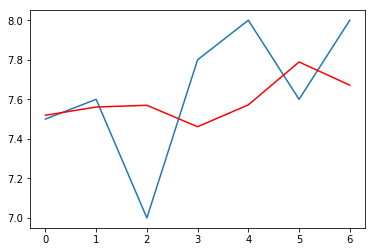

In [83]:
# Arima model, possible benchmark?
trainData = data1[0][:39].values
testData = data1[0][39:46].values

history = [x for x in trainData]
predictions = list()

for t in range(len(testData)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = testData[t]
    history.append(obs)
    
plt.plot(testData)
plt.plot(predictions, color='red')
plt.show()

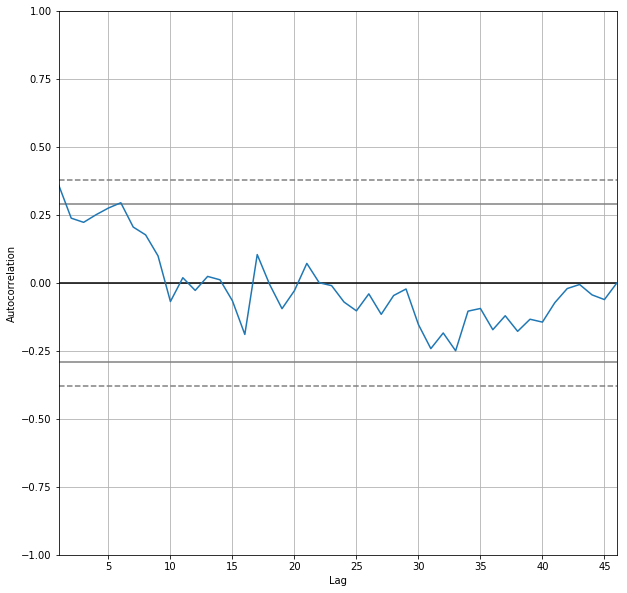

In [62]:
# Autocorrelation
moodp1 = data3[0][:46]
plt.figure(figsize=[10,10])
autocorrelation_plot(moodp1)